# ทดสอบรวมฝนรายชั่วโมงเป็นฝนรายวัน ใช้คอลัมน์ full_date และ code พลอต density ใช้ ZR RF

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import linregress
from scipy.stats import gaussian_kde
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## read cleansing 

In [2]:
df = pd.read_csv('./00Results/00rain_radar_hourly_extracted_all_events/df_org_dbz_rain_test120km.csv')
#df = pd.read_csv('./00Results/00rain_radar_hourly_extracted_all_events/df_org_dbz_rain_test200km.csv')
df.drop(df[df['cappi4km'] < 10].index, inplace = True) #ฝนอ่่อนมากๆ < 10 dBZ
df.drop(df[df['cappi4km'] > 55].index, inplace = True) #ค่าการสะท้อนที่อาจเป็นลูกเห็บ 55 dBZ มุมยกด้านบนสุด
df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df
#df.head()

,cappi1km,cappi2km,cappi3km,cappi4km,full_date,code,rain_x
0,28.491104,28.182693,27.482676,26.134428,2018-06-01-00:00,CMSG,0.0
1,18.245508,17.964867,17.979790,18.295288,2018-06-01-00:00,CTKN,10.8
2,27.273252,27.500923,27.998676,28.672308,2018-06-01-00:00,KGTP,0.0
3,27.172401,27.172401,27.172401,27.172401,2018-06-01-00:00,LPLE,0.0
4,29.211285,29.136589,24.834078,22.473293,2018-06-01-00:00,NAN008,0.0
...,...,...,...,...,...,...,...
15877,47.794342,47.810116,47.825912,47.841797,2018-09-21-23:00,PPTC,0.0
15878,21.874329,21.874329,21.874329,21.874329,2018-09-21-23:00,TBR013,0.0
15879,28.704351,28.712242,28.719904,29.000463,2018-09-21-23:00,TBW014,0.0
15880,10.786102,10.775164,10.764159,10.816386,2018-09-21-23:00,WTBT,0.0


### เปลี่ยนชื่อคอลัมน์

In [3]:
df.rename(columns={"cappi1km": "dBZ_c1", "cappi2km": "dBZ_c2","cappi3km": "dBZ_c3","cappi4km": "dBZ_c4"}, inplace=True)
df.rename(columns={"rain_x":"rain_truth"}, inplace=True)
df

,dBZ_c1,dBZ_c2,dBZ_c3,dBZ_c4,full_date,code,rain_truth
0,28.491104,28.182693,27.482676,26.134428,2018-06-01-00:00,CMSG,0.0
1,18.245508,17.964867,17.979790,18.295288,2018-06-01-00:00,CTKN,10.8
2,27.273252,27.500923,27.998676,28.672308,2018-06-01-00:00,KGTP,0.0
3,27.172401,27.172401,27.172401,27.172401,2018-06-01-00:00,LPLE,0.0
4,29.211285,29.136589,24.834078,22.473293,2018-06-01-00:00,NAN008,0.0
...,...,...,...,...,...,...,...
15877,47.794342,47.810116,47.825912,47.841797,2018-09-21-23:00,PPTC,0.0
15878,21.874329,21.874329,21.874329,21.874329,2018-09-21-23:00,TBR013,0.0
15879,28.704351,28.712242,28.719904,29.000463,2018-09-21-23:00,TBW014,0.0
15880,10.786102,10.775164,10.764159,10.816386,2018-09-21-23:00,WTBT,0.0


### คำนวน rain estimates จาก ZRs

In [4]:
## แปลง cappi เป็นฝนรายชั่วโมง ด้วย ZRs
### ZR Rosenfeld
a=250. 
b=1.2
df['rr_RF_c1']=((10**(df['dBZ_c1']/10.))/a)**(1/b)
df['rr_RF_c2']=((10**(df['dBZ_c2']/10.))/a)**(1/b)
df['rr_RF_c3']=((10**(df['dBZ_c3']/10.))/a)**(1/b)
df['rr_RF_c4']=((10**(df['dBZ_c4']/10.))/a)**(1/b)
df

,dBZ_c1,dBZ_c2,dBZ_c3,dBZ_c4,full_date,code,rain_truth,rr_RF_c1,rr_RF_c2,rr_RF_c3,rr_RF_c4
0,28.491104,28.182693,27.482676,26.134428,2018-06-01-00:00,CMSG,0.0,2.376705,2.240136,1.958572,1.512118
1,18.245508,17.964867,17.979790,18.295288,2018-06-01-00:00,CTKN,10.8,0.332794,0.315347,0.316251,0.335988
2,27.273252,27.500923,27.998676,28.672308,2018-06-01-00:00,KGTP,0.0,1.881428,1.965442,2.162418,2.460796
3,27.172401,27.172401,27.172401,27.172401,2018-06-01-00:00,LPLE,0.0,1.845370,1.845370,1.845370,1.845370
4,29.211285,29.136589,24.834078,22.473293,2018-06-01-00:00,NAN008,0.0,2.728917,2.690083,1.178211,0.749016
...,...,...,...,...,...,...,...,...,...,...,...
15877,47.794342,47.810116,47.825912,47.841797,2018-09-21-23:00,PPTC,0.0,96.511373,96.803927,97.097795,97.394194
15878,21.874329,21.874329,21.874329,21.874329,2018-09-21-23:00,TBR013,0.0,0.667694,0.667694,0.667694,0.667694
15879,28.704351,28.712242,28.719904,29.000463,2018-09-21-23:00,TBW014,0.0,2.475973,2.479725,2.483373,2.620728
15880,10.786102,10.775164,10.764159,10.816386,2018-09-21-23:00,WTBT,0.0,0.079535,0.079368,0.079201,0.079999


In [5]:
## ดรอปคอมลัมน์ cappi ทิ้ง
df.drop(columns=['dBZ_c1','dBZ_c2','dBZ_c3','dBZ_c4'], inplace=True) #ลบคอลัน์
df

,full_date,code,rain_truth,rr_RF_c1,rr_RF_c2,rr_RF_c3,rr_RF_c4
0,2018-06-01-00:00,CMSG,0.0,2.376705,2.240136,1.958572,1.512118
1,2018-06-01-00:00,CTKN,10.8,0.332794,0.315347,0.316251,0.335988
2,2018-06-01-00:00,KGTP,0.0,1.881428,1.965442,2.162418,2.460796
3,2018-06-01-00:00,LPLE,0.0,1.845370,1.845370,1.845370,1.845370
4,2018-06-01-00:00,NAN008,0.0,2.728917,2.690083,1.178211,0.749016
...,...,...,...,...,...,...,...
15877,2018-09-21-23:00,PPTC,0.0,96.511373,96.803927,97.097795,97.394194
15878,2018-09-21-23:00,TBR013,0.0,0.667694,0.667694,0.667694,0.667694
15879,2018-09-21-23:00,TBW014,0.0,2.475973,2.479725,2.483373,2.620728
15880,2018-09-21-23:00,WTBT,0.0,0.079535,0.079368,0.079201,0.079999


### รวมฝนรายชั่วโมงเป็นรายวัน ด้วยการสร้างคอลัมน์ date_only เพือ่ใช้ร่วมกับคอลัมน์ code

In [6]:
# Extract date from 'full_date' column
df['date_only'] = pd.to_datetime(df['full_date']).dt.date

# Group by 'date_only' and 'code', then sum the 'rain_truth' values
aggregated_data = df.groupby(['date_only', 'code']).sum().reset_index()

# replace NaN with 0 after aggregation using fillna(0)
#aggregated_data.fillna(0, inplace=True)

aggregated_data.dropna(inplace=True)
aggregated_data.reset_index(drop=True)

# The resulting DataFrame 'aggregated_data' will have the aggregated values
print(aggregated_data)

       date_only    code  rain_truth    rr_RF_c1    rr_RF_c2    rr_RF_c3  \
0     2018-06-01    BPPS         0.2    1.993129    2.163233    2.586858   
1     2018-06-01    BRKM         0.0    0.760334    0.781019    0.720767   
2     2018-06-01    BWKG         0.0    2.540471    2.601583    2.810899   
3     2018-06-01    CMSG         4.8   32.660637   31.823973   30.868768   
4     2018-06-01    CNDN         0.0   44.237035   44.176752   36.485195   
...          ...     ...         ...         ...         ...         ...   
2538  2018-09-21    WTBT         0.0    0.501398    0.501233    0.501072   
2539  2018-09-21    WTLG         0.0    3.003298    3.009856    3.111521   
2540  2018-09-21  YOM007         0.0    0.366247    0.348624    0.329884   
2541  2018-09-21  YOM008         0.0    0.231280    0.208045    0.217645   
2542  2018-09-21  YOM009         0.0  168.254252  168.072013  168.056031   

        rr_RF_c4  
0       2.971593  
1       0.711913  
2       2.286203  
3      27.1

In [7]:
# conditional rain
df_=aggregated_data[aggregated_data['rain_truth']>0]
df_=df_[df_['rr_RF_c1']>0]

In [8]:
df_.reset_index(drop=True, inplace=True)

In [9]:
df_.describe()

,rain_truth,rr_RF_c1,rr_RF_c2,rr_RF_c3,rr_RF_c4
count,1227.000000,1227.000000,1227.000000,1227.000000,1227.000000
mean,6.041728,48.393811,46.675708,44.434669,41.011305
std,9.312912,76.904748,72.212201,68.884078,62.882869
min,0.200000,0.133891,0.133891,0.129950,0.100139
25%,0.600000,7.681209,8.149178,7.997979,7.716233
50%,2.000000,18.631287,19.668242,19.665261,17.944076
75%,7.400000,54.725120,54.296406,52.876648,47.624060
max,77.800000,792.501507,676.013101,680.585234,735.220899


In [10]:
df_.corr()

,rain_truth,rr_RF_c1,rr_RF_c2,rr_RF_c3,rr_RF_c4
rain_truth,1.000000,0.484251,0.491446,0.478224,0.479239
rr_RF_c1,0.484251,1.000000,0.938460,0.895817,0.818039
rr_RF_c2,0.491446,0.938460,1.000000,0.950173,0.872022
rr_RF_c3,0.478224,0.895817,0.950173,1.000000,0.887354
rr_RF_c4,0.479239,0.818039,0.872022,0.887354,1.000000


## พลอต scatter คำนวณสถิติ และ พลอตค่า metrics

In [11]:
def density_plot(rain_truth, rain_radar):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import gaussian_kde
    from scipy.stats import linregress
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

    # data
    x = rain_radar
    y = rain_truth

    # Calculate the point density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    # Set the desired colorbar range
    cbar_min = 0  # specify your minimum value
    cbar_max = 0.002  # specify your maximum value

    # Create scatter plot with density color map
    fig, ax = plt.subplots()
    scatter = ax.scatter(x, y, c=z, s=20, cmap='jet', alpha=0.8, vmin=cbar_min, vmax=cbar_max)

    
    max_ = 50
    # Set x and y axis limits
    plt.xlim(0, max_)
    plt.ylim(0, max_)

    # Plot the 1:1 line
    plt.plot([0, max_], [0, max_], linestyle='-', color='black', linewidth=2)

    plt.xlabel('rain_truth [mm/hr]')
    plt.ylabel('rain_radar [mm/hr]')

    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Density')

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(x, y))
    mse = mean_squared_error(x, y)
    mae = mean_absolute_error(x, y)
    r2 = r2_score(x, y)

    # Calculate p-value and correlation coefficient (r)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Print results
    print(f'RMSE: {rmse}')
    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    print(f'R-squared: {r2}')
    print(f'Correlation coefficient (r): {r_value}')
    print(f'P-value: {p_value}')

    # Plot the regression line
    plt.plot(x, slope * x + intercept, linestyle='-', color='magenta', linewidth=2,
             label=f'Regression Line (r={r_value:.2f}, p={p_value:.4f})')
    plt.xlabel('rain_radar [mm/day]')
    plt.ylabel('rain_truth [mm/day]')
    plt.title('Daily rain_radar and rain_truth [mm/day]')
    plt.legend()

    # Display the plot
    plt.show()


RMSE: 84.24248397263818
MSE: 7096.796105880201
MAE: 42.754366978770705
R-squared: -0.20090903671689397
Correlation coefficient (r): 0.48425090630389367
P-value: 3.875835117232847e-73


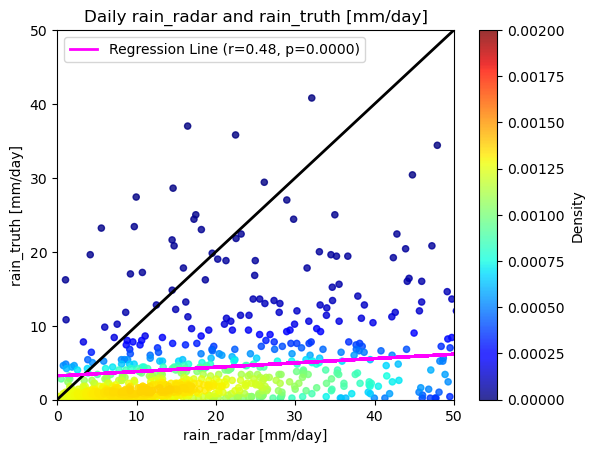

In [12]:
density_plot(df_['rain_truth'],df_['rr_RF_c1'])

RMSE: 79.2948296083339
MSE: 6287.670002614706
MAE: 40.87855068021421
R-squared: -0.20676489211146287
Correlation coefficient (r): 0.4914461291771271
P-value: 1.3527918172202774e-75


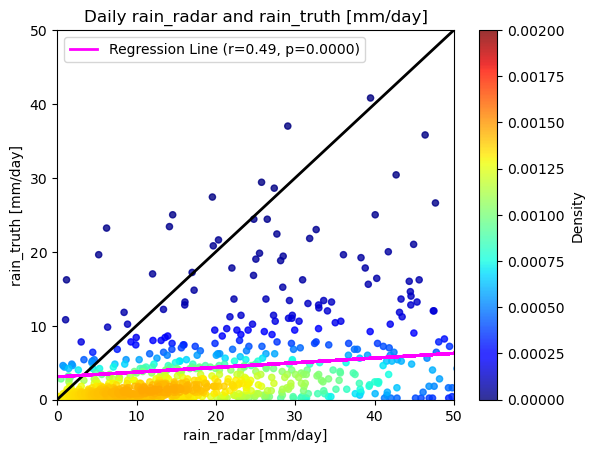

In [13]:
density_plot(df_['rain_truth'],df_['rr_RF_c2'])

RMSE: 75.42383592518433
MSE: 5688.7550256691275
MAE: 38.61208368915577
R-squared: -0.19986842117192305
Correlation coefficient (r): 0.47822355003060474
P-value: 3.999709605739674e-71


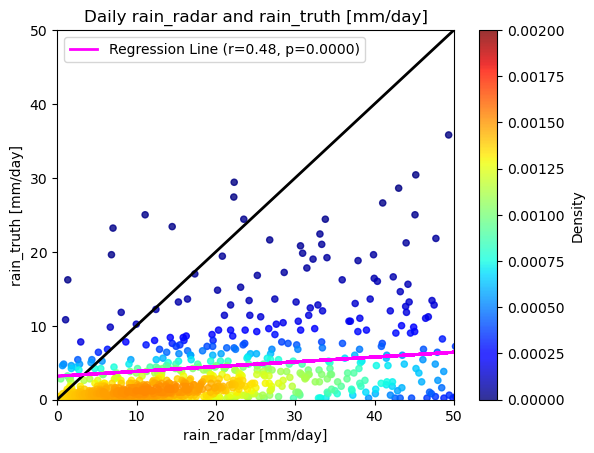

In [14]:
density_plot(df_['rain_truth'],df_['rr_RF_c3'])

RMSE: 68.55446358199973
MSE: 4699.714477015727
MAE: 35.214147648325934
R-squared: -0.18949018743414503
Correlation coefficient (r): 0.4792390854799929
P-value: 1.8431646422798225e-71


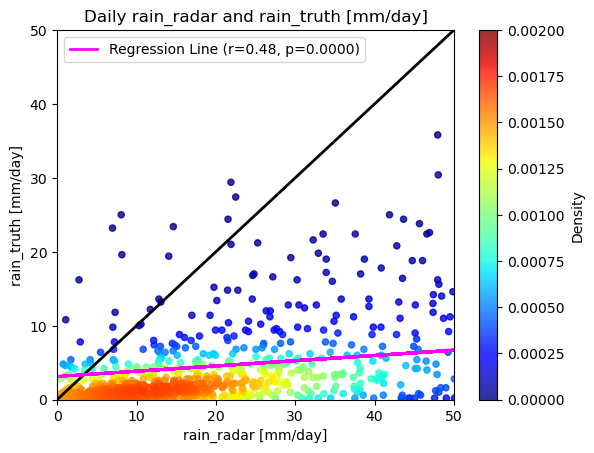

In [15]:
density_plot(df_['rain_truth'],df_['rr_RF_c4'])

### คำนวณสถิติ และ พลอตค่า metrics

In [16]:
def density_plot_joint(rain_truth,rain_radar):
    # data
    x = rain_radar
    y = rain_truth

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(x, y))
    mse = mean_squared_error(x, y)
    mae = mean_absolute_error(x, y)
    r2 = r2_score(x, y)

    # Calculate p-value and correlation coefficient (r)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Print results
    print(f'RMSE: {rmse}')
    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    print(f'R-squared: {r2}')
    print(f'Correlation coefficient (r): {r_value}')
    print(f'P-value: {p_value}')

    # Calculate the point density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    
    # Set the desired colorbar range
    cbar_min = 0  # specify your minimum value
    cbar_max = 0.002  # specify your maximum value

    # Create a joint plot with scatter plot, regression line, and density plot
    sns.set(style="whitegrid")
    g = sns.jointplot(x=x, y=y, kind="reg", height=7)
    plt.plot(x, slope * x + intercept, linestyle='-', color='magenta', linewidth=2,
             label=f'Regression Line (r={r_value:.2f}, p={p_value:.4f})')
    #plt.text(0.5, 0.9, f'r = {r_value:.2f}, p = {p_value:.4f}', horizontalalignment='center', verticalalignment='center', transform=g.ax_joint.transAxes)

    # Add scatter plot with density color map
    scatter = plt.scatter(x, y, c=z, s=20, cmap='jet', alpha=0.8, vmin=cbar_min, vmax=cbar_max)
    
    # Set scatter plot aspect ratio to be equal
    #plt.gca().set_aspect('equal', adjustable='box')
    
    max_=50

    # Set x and y axis limits
    plt.xlim(0, max_)
    plt.ylim(0, max_)

    # Plot the 1:1 line
    plt.plot([0, max_], [0, max_], linestyle='-', color='black', linewidth=2)

    plt.xlabel('rain_radar [mm/day]')
    plt.ylabel('rain_truth [mm/day]')
    plt.title('Daily rain_radar and rain_truth [mm/day]')

    # Add colorbar using the scatter variable
    cbar = plt.colorbar(scatter)
    cbar.set_label('Density')

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Display the plot
    plt.show()


RMSE: 84.24248397263818
MSE: 7096.796105880201
MAE: 42.754366978770705
R-squared: -0.20090903671689397
Correlation coefficient (r): 0.48425090630389356
P-value: 3.875835117233401e-73


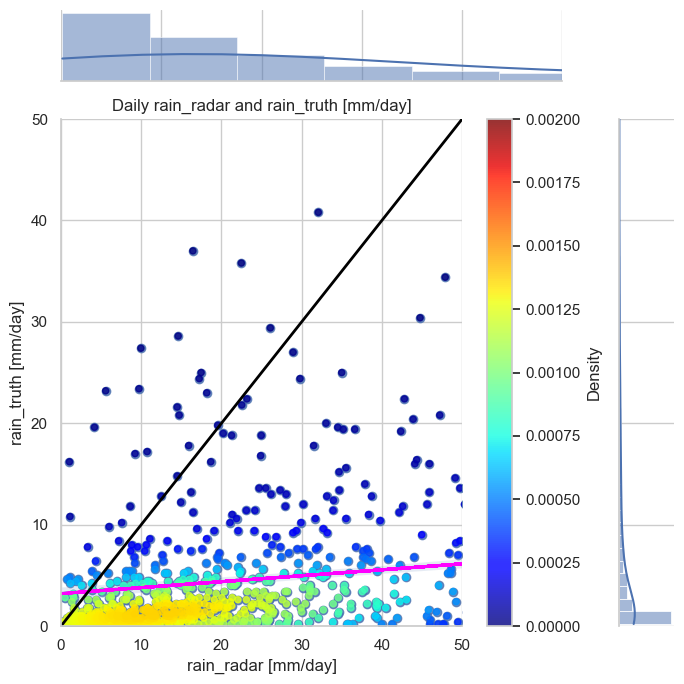

In [17]:
density_plot_joint(df_['rain_truth'],df_['rr_RF_c1'])

RMSE: 79.2948296083339
MSE: 6287.670002614707
MAE: 40.87855068021421
R-squared: -0.20676489211146287
Correlation coefficient (r): 0.4914461291771263
P-value: 1.3527918172211257e-75


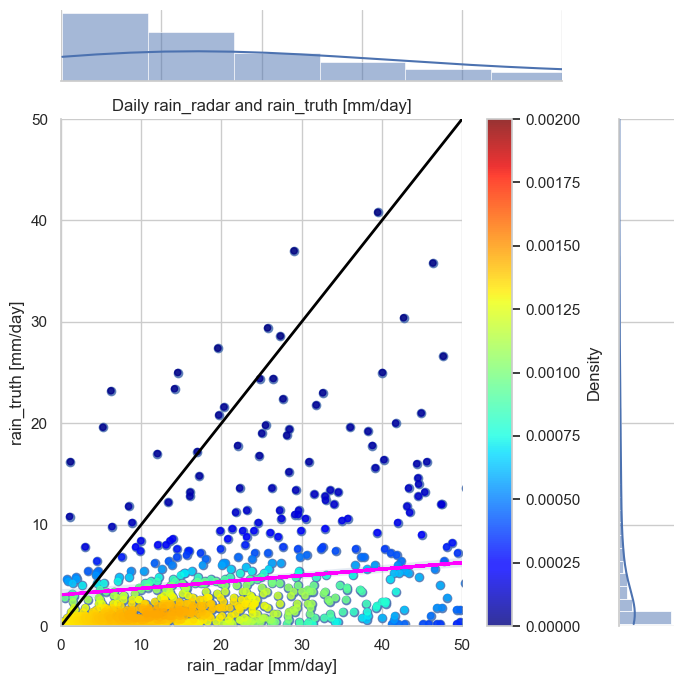

In [18]:
density_plot_joint(df_['rain_truth'],df_['rr_RF_c2'])

RMSE: 75.42383592518433
MSE: 5688.7550256691275
MAE: 38.61208368915577
R-squared: -0.19986842117192305
Correlation coefficient (r): 0.47822355003060457
P-value: 3.999709605740244e-71


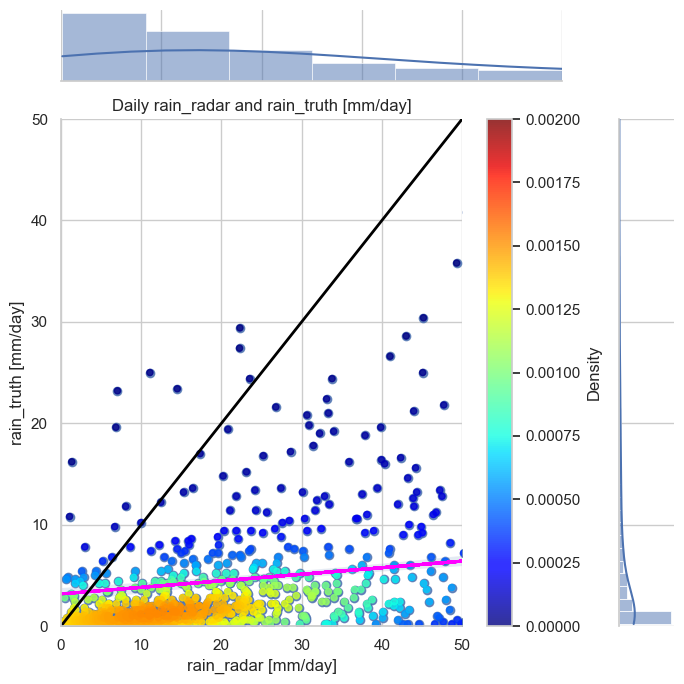

In [19]:
density_plot_joint(df_['rain_truth'],df_['rr_RF_c3'])

RMSE: 68.55446358199974
MSE: 4699.714477015729
MAE: 35.214147648325934
R-squared: -0.18949018743414525
Correlation coefficient (r): 0.47923908547999283
P-value: 1.8431646422798756e-71


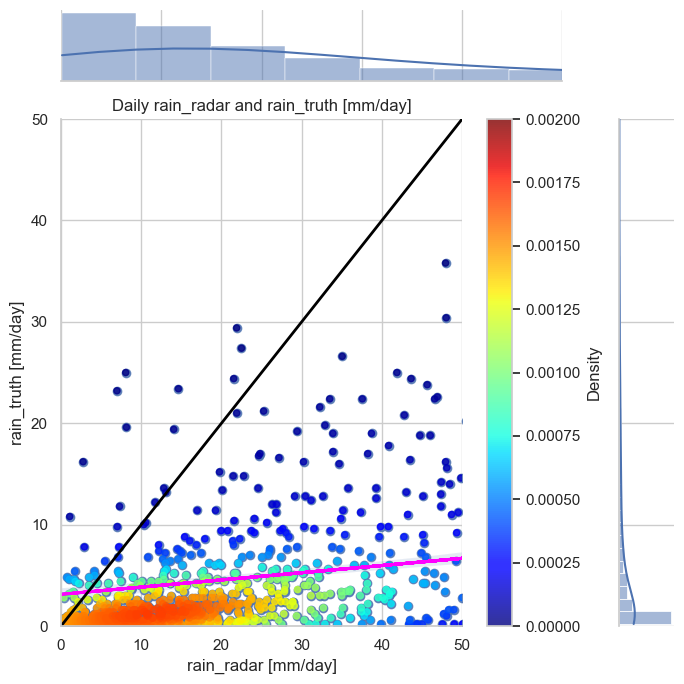

In [20]:
density_plot_joint(df_['rain_truth'],df_['rr_RF_c4'])

## รวมฝนรายวันเป็นฝนทั้งเหตุการณ์ของแต่ละสถานี

In [21]:
def density_plot_joint_events(rain_truth,rain_radar):
    # data
    x = rain_radar
    y = rain_truth

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(x, y))
    mse = mean_squared_error(x, y)
    mae = mean_absolute_error(x, y)
    r2 = r2_score(x, y)

    # Calculate p-value and correlation coefficient (r)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Print results
    print(f'RMSE: {rmse}')
    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    print(f'R-squared: {r2}')
    print(f'Correlation coefficient (r): {r_value}')
    print(f'P-value: {p_value}')

    # Calculate the point density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    
    # Set the desired colorbar range
    cbar_min = 0  # specify your minimum value
    cbar_max = 0.002  # specify your maximum value

    # Create a joint plot with scatter plot, regression line, and density plot
    sns.set(style="whitegrid")
    g = sns.jointplot(x=x, y=y, kind="reg", height=7)
    plt.plot(x, slope * x + intercept, linestyle='-', color='magenta', linewidth=2,
             label=f'Regression Line (r={r_value:.2f}, p={p_value:.4f})')
    #plt.text(0.5, 0.9, f'r = {r_value:.2f}, p = {p_value:.4f}', horizontalalignment='center', verticalalignment='center', transform=g.ax_joint.transAxes)

    # Add scatter plot with density color map
    scatter = plt.scatter(x, y, c=z, s=10, cmap='jet', alpha=0.8, vmin=cbar_min, vmax=cbar_max)
    
    # Set scatter plot aspect ratio to be equal
    #plt.gca().set_aspect('equal', adjustable='box')

    # Set x and y axis limits
    max_=50
    plt.xlim(0, max_)
    plt.ylim(0, max_)

    # Plot the 1:1 line
    plt.plot([0, max_], [0, max_], linestyle='-', color='black', linewidth=2)

    plt.xlabel('rain_radar [mm]')
    plt.ylabel('rain_truth [mm]')
    plt.title('Events rain_radar and rain_truth [mm]')

    # Add colorbar using the scatter variable
    cbar = plt.colorbar(scatter)
    cbar.set_label('Density')

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Display the plot
    plt.show()

In [22]:
df_

,date_only,code,rain_truth,rr_RF_c1,rr_RF_c2,rr_RF_c3,rr_RF_c4
0,2018-06-01,BPPS,0.2,1.993129,2.163233,2.586858,2.971593
1,2018-06-01,CMSG,4.8,32.660637,31.823973,30.868768,27.195866
2,2018-06-01,CTKN,10.8,1.120512,1.062269,1.060844,1.079197
3,2018-06-01,KGKG,0.4,10.378715,11.455584,12.345067,10.716323
4,2018-06-01,KGLN,0.2,56.511044,55.829830,49.871732,7.775935
...,...,...,...,...,...,...,...
1222,2018-09-20,WTLG,0.2,5.540208,5.390976,5.237828,1.500068
1223,2018-09-21,CNDN,0.2,2.686731,2.948859,2.649804,2.234649
1224,2018-09-21,NAN013,24.8,271.573720,273.116304,277.063212,296.100211
1225,2018-09-21,PIN003,2.4,53.975734,50.862834,41.556505,27.417169


In [23]:
import pandas as pd

# Assuming df_ is your DataFrame
# Group by 'code' and calculate the mean for each group
aggregated_df = df_.groupby('code').mean().reset_index()

# Display the aggregated DataFrame
print("Aggregated DataFrame:")
df_=aggregated_df
print(df_)


Aggregated DataFrame:
      code  rain_truth   rr_RF_c1   rr_RF_c2   rr_RF_c3    rr_RF_c4
0     BDLH    5.726316  31.382569  26.167225  22.616310   21.305696
1     BMNK    0.200000   4.167597   4.602579   5.125294    5.450351
2     BPPS    5.341176  49.823297  41.336143  30.773825   24.242520
3     BRKM    3.333333  27.210231  27.163269  26.513616   22.406496
4     BWKG    5.162500  21.362588  21.265629  21.395808   22.198503
..     ...         ...        ...        ...        ...         ...
81  YOM006    4.892308  27.082173  25.467466  23.940536   21.973608
82  YOM007    3.800000  30.170685  35.646455  48.710809  100.605812
83  YOM008    4.781818  25.550767  25.900469  26.112656   30.839338
84  YOM009    7.600000  62.857332  81.495400  78.803843   70.672221
85  YOM012    0.342857  53.489887  54.116990  53.788472   52.923790

[86 rows x 6 columns]


In [24]:
df_.corr()

,rain_truth,rr_RF_c1,rr_RF_c2,rr_RF_c3,rr_RF_c4
rain_truth,1.000000,0.470147,0.477818,0.460854,0.438099
rr_RF_c1,0.470147,1.000000,0.988018,0.954790,0.899404
rr_RF_c2,0.477818,0.988018,1.000000,0.984181,0.936131
rr_RF_c3,0.460854,0.954790,0.984181,1.000000,0.968765
rr_RF_c4,0.438099,0.899404,0.936131,0.968765,1.000000


RMSE: 58.98544528923828
MSE: 3479.2827559697225
MAE: 44.80535980933187
R-squared: -1.207771578560585
Correlation coefficient (r): 0.4701465805905544
P-value: 4.939335767661616e-06


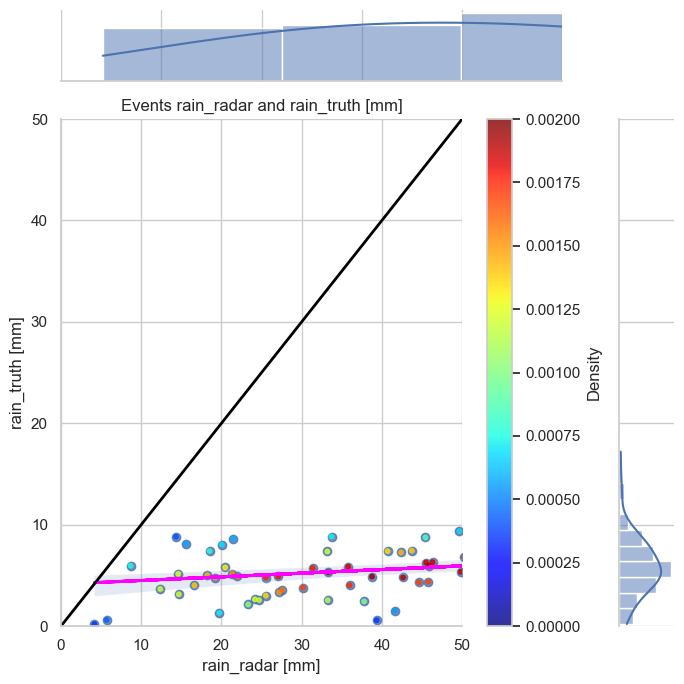

In [25]:
density_plot_joint_events(df_['rain_truth'],df_['rr_RF_c1'])

RMSE: 57.64121897568445
MSE: 3322.5101250028056
MAE: 43.47832612051389
R-squared: -1.162085349412548
Correlation coefficient (r): 0.4778181133077296
P-value: 3.2821921418570083e-06


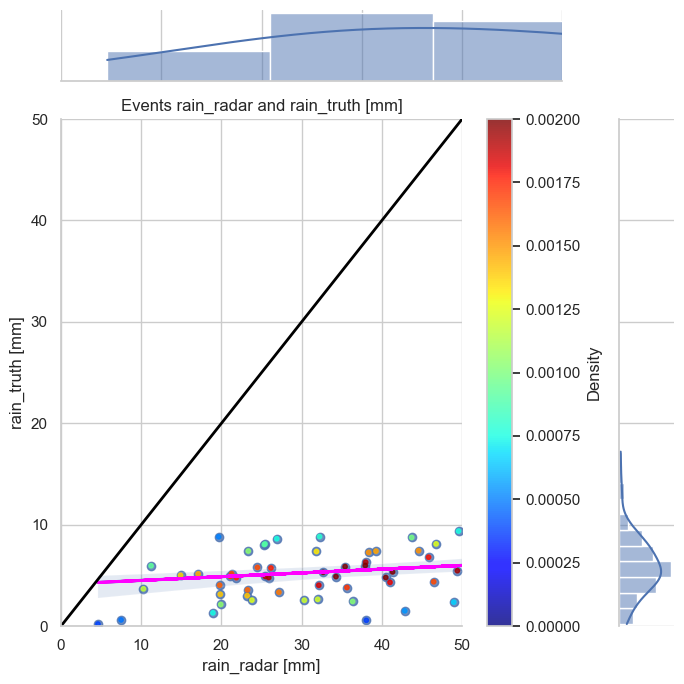

In [26]:
density_plot_joint_events(df_['rain_truth'],df_['rr_RF_c2'])

RMSE: 58.02701414921373
MSE: 3367.1343710730503
MAE: 41.71869509536414
R-squared: -0.9417754665224178
Correlation coefficient (r): 0.46085414682391296
P-value: 7.998708560269257e-06


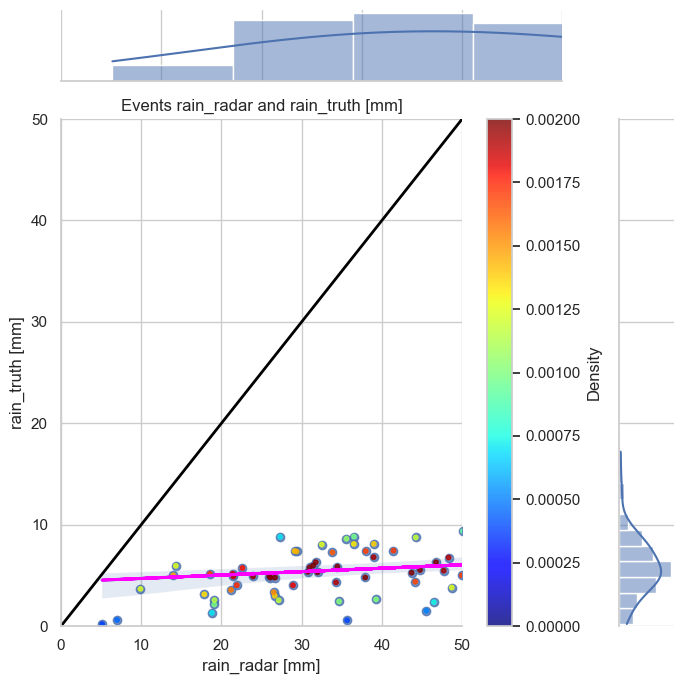

In [27]:
density_plot_joint_events(df_['rain_truth'],df_['rr_RF_c3'])

RMSE: 53.4936877044952
MSE: 2861.574624226061
MAE: 38.53127226954853
R-squared: -0.9470111696425072
Correlation coefficient (r): 0.4380990222948434
P-value: 2.458107150543362e-05


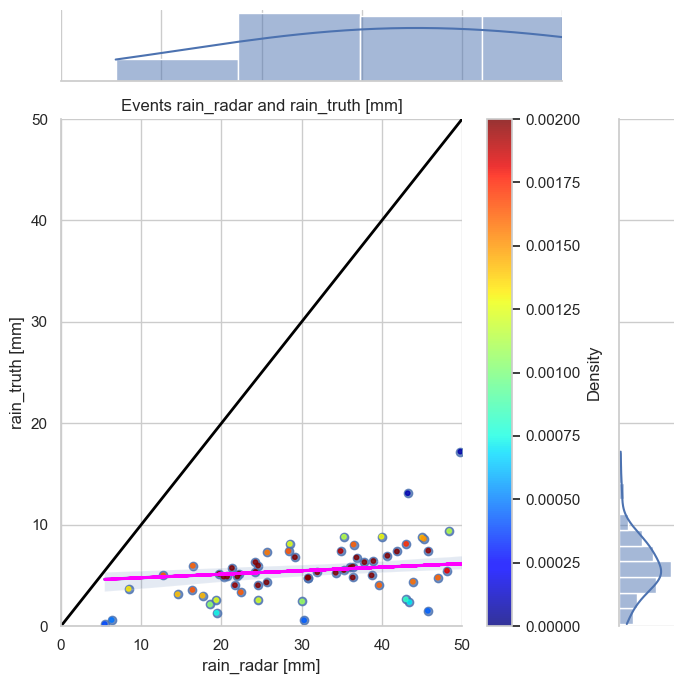

In [28]:
density_plot_joint_events(df_['rain_truth'],df_['rr_RF_c4'])

## หา bias และปรับแก้แบบ MFB Mean Field Bias Correction